# 1.Sigmoid激活函数的梯度消失问题
- 理论说明

    对于sigmoid激活函数来说，简单的叠加是极容易出现梯度消失的问题。sigmoid函数及导函数图像如下所示：


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [15]:
# 绘制Sigmoid函数的函数图像和导函数图像
X = torch.arange(-5, 5, 0.1)
# 追踪X的操作,为后续的反向传播计算梯度
X.requires_grad=True
sigmoid_y = torch.sigmoid(X)

In [17]:
# 反向传播
sum = sigmoid_y.sum()
print(sum)
sum.backward()

tensor(49.5067, grad_fn=<SumBackward0>)


Text(0.5, 1.0, 'Sigmoid Derivative function')

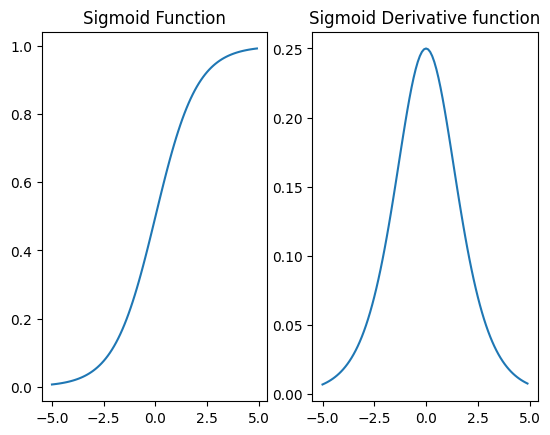

In [5]:
# Sigmoid函数图像
plt.subplot(121)
plt.plot(X.detach(), sigmoid_y.detach())
plt.title("Sigmoid Function")
# Sigmoid导函数图像
plt.subplot(122)
plt.plot(X.detach(), X.grad.detach())
plt.title("Sigmoid Derivative function")

我们发现，Sigmoid导函数最大值为0.25（在0点处取到），当x较大或者较小时，导函数取值趋于0。

梯度消失或者梯度爆炸，始终是个概率问题。

我们不能说导函数取值取值小就一定会发生梯度消失问题，只是导函数最大值越小，越有可能发生梯度消失。

- Sigmoid函数饱和区间

一般来说我们会将靠近sigmoid函数的左右两端的区间称为函数的饱和区间（如下图圈出部分）（也就是自变量绝对值较大的区间），不难发现，当自变量落入饱和区间时，因变量会趋于0或者1，而无论自变量是极小（负数绝对值极大）还是极大，都会使得导函数取值趋于0，从而更容易导致模型梯度消失。


In [18]:
import torch
import torch.nn as nn
import numpy as np

# 设置随机种子
np.random.seed(0)
torch.manual_seed(0)

# 如果有GPU可用，使用GPU加速
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [19]:
class SimpleNetWork(nn.Module):
    def __init__(self, layers):
        super(SimpleNetWork, self).__init__()
        # 初始化一个Layer容器
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))
            self.layers.append(nn.Sigmoid())
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
# 定义一个深层网络
input_size = 1
hidden_sizes = [64] * 10
output_size = 1
layers = [input_size] + hidden_sizes + [output_size]
model = SimpleNetWork(layers).to(device)

In [20]:
#创建一个随机输入
input_data = torch.randn(1, input_size).to(device)
output = model(input_data)
print("Output shape", output.shape)

Output shape torch.Size([1, 1])


In [22]:
# loss func
loss_fn = nn.MSELoss()
# 假设目标值为0.5
target = torch.tensor([[0.5]]).to(device)
loss = loss_fn(output, target)

print("Initial Loss:", loss.item())

Initial Loss: 0.002793394261971116


In [23]:
# 梯度清零
model.zero_grad()
loss.backward()

first_layer_grad = list(model.parameters())[0].grad
last_layer_grad = list(model.parameters())[-2].grad
print("First Layer Weight Grad:", first_layer_grad.abs().mean().item())
print("Last Layer Weight Grad:", last_layer_grad.abs().mean().item())

First Layer Weight Grad: 1.400428601208703e-12
Last Layer Weight Grad: 0.012725934386253357


由于Sigmoid激活函数叠加会造成严重梯度消失问题
因此复杂模型，如Sigmoid3和Sigmoid4的前几层在迭代过程中逐渐丧失变化的可能性，也就是学习能力，从而导致经过了很多轮的迭代
但最终结果只能和Sigmoid2和Sigmoid3持平的情况。
```text
需要注意的是，对于复杂模型来说，如果部分层失去学习能力（参数迭代的可能性），其实模型判别效力就和简单模型无异。从此也能看出对复杂模型进行有效训练的重要性。
```